### <B>Downloading GNSS measurements from UNR for DISP-S1 CalVal</B>
- Downloading GNSS stations within a DISP-S1 frame using MintPy
- Filtering GNSS stations based on density and periods of observation and significant steps

In [1]:
import geopandas as gpd
import pandas as pd
import json

import os 
import numpy as np
import datetime as dt

import requests
from io import BytesIO
import zipfile

from tqdm import tqdm

from scipy.signal import find_peaks

import ruptures as rpt      # for detecting significant steps (pip install ruptures)

from mintpy.objects import gnss

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

In [2]:
def detect_step_functions(dates, time_series, penalty=1, threshold=0.1, window_size=10):
    """
    Detect significant step functions and stair-like features in a time series with corresponding dates.
    
    Args:
    dates (list): List of dates corresponding to the time series data.
    time_series (list or numpy.array): The input time series data.
    penalty (float): Penalty term for the change point detection algorithm. Default is 1.
    threshold (float): The minimum relative change to consider as a significant step. Default is 0.1 (10%).
    window_size (int): Size of the window for local trend analysis. Default is 10.
    
    Returns:
    list: List of tuples (date, index, step_type) where significant step functions or stairs are detected.
    """
    # Convert input to numpy array if it's a list
    if isinstance(time_series, list):
        time_series = np.array(time_series)
    
    # Ensure dates and time_series have the same length
    if len(dates) != len(time_series):
        raise ValueError("The lengths of dates and time_series must be the same.")
    
    # Fit the change point detection model
    model = rpt.Pelt(model="rbf").fit(time_series.reshape(-1, 1))
    
    # Find the change points
    change_points = model.predict(pen=penalty)
    
    # Calculate first differences
    diff = np.diff(time_series)
    
    # Find peaks in the absolute differences (potential steps)
    peaks, _ = find_peaks(np.abs(diff), height=np.std(diff)*2)
    
    # Combine change points and peaks
    all_points = sorted(set(change_points[1:]).union(set(peaks)))
    
    # Filter significant steps and detect stair-like features
    significant_features = []
    for point in all_points:
        before = np.mean(time_series[max(0, point-window_size):point])
        after = np.mean(time_series[point:min(point+window_size, len(time_series))])
        
        relative_change = (after - before) / abs(before)
        
        if abs(relative_change) > threshold:
            # Check for stair-like feature
            if point + window_size < len(time_series):
                next_window = np.mean(time_series[point+window_size:min(point+2*window_size, len(time_series))])
                if abs((next_window - after) / after) < threshold/2:
                    significant_features.append((dates[point], point, "stair"))
                else:
                    significant_features.append((dates[point], point, "step"))
            else:
                significant_features.append((dates[point], point, "step"))
    
    return significant_features

In [3]:
def plot_gnss_stations_frame(sites_df, geom, figname, title="GNSS Stations with Frame", plot_buffer=0.2):
    """ 
    Plotting GNSS stations with DISP-S1 frame
    """
    # Create a new figure and axes with Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add Google Terrain tiles as basemap
    terrain_tiles = GoogleTiles(style='satellite')
    ax.add_image(terrain_tiles, 10)  # zoom level, adjust as needed

    # Add coastlines and borders for additional clarity
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # Plot the frame geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)

    # Plot GNSS stations
    ax.scatter(sites_df.lon, sites_df.lat, transform=ccrs.PlateCarree(), color='blue', s=50, zorder=5)

    # Add labels for GNSS stations
    for idx, row in sites_df.iterrows():
        ax.text(row.lon, row.lat, row.site, transform=ccrs.PlateCarree(), fontsize=8, 
                ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Set the extent of the map to focus on the area of interest
    bounds = geom.bounds
    ax.set_extent([bounds[0]-plot_buffer, bounds[2]+plot_buffer, bounds[1]-plot_buffer, bounds[3]+plot_buffer], crs=ccrs.PlateCarree())

    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Add north arrow
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(arrowstyle='simple',facecolor='white'),
                ha='center', va='center', fontsize=20, color='white',
                xycoords=ax.transAxes)
    
    # Add custom scale bar
    scale_bar_length = 10  # km
    scale_bar_x = 0.9
    scale_bar_y = 0.05
    
    # Get current axis limits
    x_lims = ax.get_xlim()
    y_lims = ax.get_ylim()
    
    # Calculate scale bar length in degrees (approximate)
    scale_bar_length_deg = scale_bar_length / 111  # 1 degree is approximately 111 km
    
    # Draw scale bar
    ax.plot([scale_bar_x, scale_bar_x + scale_bar_length_deg], [scale_bar_y, scale_bar_y], 
            transform=ax.transAxes, color='white', linewidth=4, solid_capstyle='butt')
    
    # Add scale bar label
    ax.text(scale_bar_x + scale_bar_length_deg/2, scale_bar_y + 0.01, f'{scale_bar_length} km', 
            transform=ax.transAxes, ha='center', va='bottom', color='white', fontsize=12, 
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2))
    
    # Reset axis limits (they might have changed when adding the scale bar)
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    
    plt.title(title)

    plt.tight_layout()
    plt.savefig(figname, bbox_inches='tight', transparent=True, dpi=300)

In [4]:
def read_UNR_gnss_step(url):
    """ 
    reading steps.txt file in UNR database
    : including info about equipment changes and earthquake occurrences
    
    """

    # fetch the content from the URL
    response = requests.get(url)
    content = response.text

    # Initialize lists to store data
    data = []
    
    # Process the content line by line
    for line in content.split('\n'):
        if line.strip() == '':
            continue  # Skip empty lines
        
        parts = line.split()
        if len(parts) < 3:
            continue  # Skip lines with insufficient data
        
        code = int(parts[2])
        
        if code == 1 and len(parts) >= 4:
            data.append(parts[:4])
        elif code == 2 and len(parts) >= 7:
            data.append(parts[:7])

    # Create DataFrame
    columns = ['site', 'step_date', 'code', 'type_threshold', 'distance_to_epicenter', 'magnitude', 'eventID']
    df = pd.DataFrame(data, columns=columns)
    
    # Convert data types
    df['code'] = df['code'].astype(int)
    
    # Convert column2 to datetime
    df['step_date'] = pd.to_datetime(df['step_date'], format='%y%b%d', errors='coerce')
    
    for col in df.columns:
        if col not in ['code', 'step_date']:  # Skip code and date columns
            df[col] = pd.to_numeric(df[col], errors='ignore')
    
    return df

Input parameters

In [5]:
frameID = 8882     # frameID to download GNSS stations
frameID_str = str(frameID).zfill(5)    # forced to have 5 digit for frameID string 
mintpy_dir = 'mintpy_output'
os.makedirs(mintpy_dir, exist_ok='True')

# gnss-related parameters
gnss_source = 'UNR'
gnss_all_list_csv = f'gnss_all_station_list_F{frameID_str}.csv'     # locate in mintpy_dir
gnss_select_list_csv = 'gnss_select_station_list_F{frameID_str}.csv'     # locate in mintpy_dir (Note: this csv file will be used for further DISP-S1 CalVal)
gnss_dirname = f'GNSS-{gnss_source}'
gnss_dir = os.path.join(mintpy_dir,gnss_dirname)
os.makedirs(gnss_dir, exist_ok='True')
gnss_thr_density = 0.3      # thresholded by density of measurements 
gnss_thr_eq = 6.0           # threshold of earthquake magnitude for removing GNSS stations
gnss_thr_eq_dist = 20          # threshold of earthquake distance (km) from station to epicenter for removing GNSS stations
gnss_completeness_thr = 0.6     # threshold of how densely GNSS measured in time (filtering based on sparsity)     
gnss_coverage_thr = 0.2         # threshold of GNSS observations during DISP-S1 time range  (filtering based on low temporal coverage)
gnss_steps_url = 'http://geodesy.unr.edu/NGLStationPages/steps.txt'     #potential steps file in GNSS time series
bad_gnss_dirname = 'gnss_bad'
bad_gnss_dir = os.path.join(gnss_dir, bad_gnss_dirname)
os.makedirs(bad_gnss_dir, exist_ok='True')

# DISP-S1 time-range for downloading GNSS stations
start_date = '20140101'
start_date = dt.datetime.strptime(start_date ,'%Y%m%d')     #YYMMDD to datetime 
end_date = dt.datetime.now()    # end_date = '20231231'; end_date = dt.datetime.strptime(end_date ,'%Y%m%d') 
DISP_S1_period = (end_date - start_date).days

Reading DISP-S1 frame

In [6]:
# Extracting DISP-S1 frame 
# URL of the ZIP file containing the JSON file
repo_zip_url = 'https://github.com/opera-adt/burst_db/releases/download/v0.5.0/frame-geometries-simple-0.5.0.geojson.zip'

# Download the ZIP file
response = requests.get(repo_zip_url)
zip_data = BytesIO(response.content)

# Extract the JSON file from the ZIP archive
with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    # Assuming your JSON file is named 'data.json' within the ZIP
    json_data = zip_ref.read('frame-geometries-simple-0.5.0.geojson')

# Load the JSON data
data = json.loads(json_data.decode('utf-8')) # ['features']

gdf = gpd.GeoDataFrame.from_features(data)
gdf['frameID'] = pd.json_normalize(data["features"])["id"].values     # ID in 'feature' of geojson is added
gdf = gdf.set_crs(epsg=4326)        # defining crs of geopandas table

gdf.head()

,geometry,is_land,is_north_america,orbit_pass,frameID
0,"POLYGON ((2.53190 4.75701, 2.21493 6.28652, 4....",1,0,ASCENDING,4
1,"POLYGON ((1.93907 7.62125, 4.15397 8.19614, 4....",1,0,ASCENDING,5
2,"POLYGON ((1.66390 8.95599, 3.88743 9.52738, 4....",1,0,ASCENDING,6
3,"POLYGON ((1.38921 10.29072, 3.62257 10.85865, ...",1,0,ASCENDING,7
4,"POLYGON ((1.11482 11.62540, 3.35926 12.18994, ...",1,0,ASCENDING,8


In [7]:
gdf_select = gdf[gdf['frameID']==frameID]
display(gdf_select)

geom = gdf_select['geometry'].values[0]         # geometry of extracted frameID

,geometry,is_land,is_north_america,orbit_pass,frameID
4069,"POLYGON ((-97.38477 30.02259, -94.83005 30.547...",1,1,ASCENDING,8882


Reading possible steps in GNSS stations

In [8]:
gnss_steps_df = read_UNR_gnss_step(gnss_steps_url)      # reading UNR step file

# gnss_steps_ant_df: table for equipment changes
gnss_steps_ant_df = gnss_steps_df[gnss_steps_df['code']==1].reset_index(drop=True)       # equipment (antenna, receiver or firmware) changes
gnss_steps_ant_df = gnss_steps_ant_df.iloc[:, :4]
_cols = gnss_steps_ant_df.columns.tolist(); _cols[3] = 'type'; gnss_steps_ant_df.columns = _cols

# gnss_steps_ant_df: table for earthquake occurrences
gnss_steps_eq_df = gnss_steps_df[gnss_steps_df['code']==2].reset_index(drop=True)       # earthquake event
_cols = gnss_steps_eq_df.columns.tolist(); _cols[3] = 'threshold_distance'; gnss_steps_eq_df.columns = _cols

In [9]:
# filtering equipment changed based on dates
print('Type of equipment changes: ', gnss_steps_ant_df['type'].unique())
prob_changes = ['Antenna_detached_from_monument', 'Equipment_Site_Change']      # list of problematic equipment changes; can be expanded
gnss_steps_ant_df = gnss_steps_ant_df[gnss_steps_ant_df['type'].isin(prob_changes)]     # if the type of equipment changes belong to problematic list
gnss_steps_ant_df = gnss_steps_ant_df[(gnss_steps_ant_df['step_date']>= start_date) & (gnss_steps_ant_df['step_date']<= end_date)].reset_index(drop=True)

# filter gnss stations based on earthquake magnitude, distance, dates
gnss_steps_eq_df = gnss_steps_eq_df[(gnss_steps_eq_df['distance_to_epicenter']<gnss_thr_eq_dist) & (gnss_steps_eq_df['magnitude']>gnss_thr_eq)]
gnss_steps_eq_df = gnss_steps_eq_df[(gnss_steps_eq_df['step_date'] >= start_date) & (gnss_steps_eq_df['step_date'] <= end_date)].reset_index(drop=True)

Type of equipment changes:  ['Antenna_Code_Changed' 'Receiver_Make_and_Model_Changed'
 'Elevation_Cutoff_Changed' 'Radome_Code_Changed' 'Logfile_Changed'
 'Antenna_and_Radome_Codes_Changed' 'Receiver_Make_Changed'
 'Unknown_Event' 'Gull_Deterrent_Installed'
 'Receiver_make_and_model_changed' 'Receiver_Model_Changed'
 'Receiver_Setting_Corrected' 'CCV3_monument_changed,_became_station_CCV5'
 'Unknown' 'Antenna_Changed' 'Monument_Pin_Moved' 'Equipment_Site_Change'
 'Unspecified_Change' 'Volcanic_Eruption' 'Antenna_change'
 'Monument_pin_rethreaded' 'Antenna_Mount_Changed' 'Unknown_event'
 'Antenna_detached_from_monument']


In [10]:
display(gnss_steps_ant_df.head())
display(gnss_steps_eq_df.head())

,site,step_date,code,type
0,WIRP,2017-09-11,1,Equipment_Site_Change
1,YAVC,2017-10-01,1,Antenna_detached_from_monument


,site,step_date,code,threshold_distance,distance_to_epicenter,magnitude,eventID
0,PTOI,2014-01-20,2,181.970,16.900,6.1,usb000m4i4
1,TINT,2014-01-20,2,181.970,14.282,6.1,usb000m4i4
2,KIPO,2014-01-26,2,181.970,9.143,6.1,usb000m8ch
3,VLSM,2014-01-26,2,181.970,12.374,6.1,usb000m8ch
4,MOM0,2014-04-10,2,181.970,17.661,6.1,usd0003cqx


Filtering GNSS stations initially based on density of observations 

In [11]:
# specify GNSS source for validation
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)

site_list_file = gnss.GNSS_SITE_LIST_URLS[gnss_source]

if gnss_source == 'UNR':
    sites = gnss.read_UNR_site_list(site_list_file)
elif gnss_source == 'ESESES':
    sites = gnss.read_ESESES_site_list(site_list_file)
elif gnss_source == 'SIDESHOW':
    sites = gnss.read_SIDESHOW_site_list(site_list_file)
elif gnss_source == 'GENERIC':
    sites = gnss.read_GENERIC_site_list(site_list_file)

Searching for all GNSS stations from source: UNR
May use any of the following supported sources: ['UNR', 'ESESES', 'JPL-SIDESHOW', 'GENERIC']


In [12]:
# ensure that site data formatting is consistent
sites['site'] = np.array([site.upper() for site in sites['site']])
sites['lon'][sites['lon'] > 180] -= 360         # ensure lon values in (-180, 180]

sites_df = pd.DataFrame.from_dict(sites)

_nrow, _ = sites_df.shape
print(f'{_nrow} GNSS sites are found in {gnss_source}.')

22225 GNSS sites are found in UNR.


In [13]:
time_diff = (sites_df['end_date'] - sites_df['start_date']).apply(lambda x: x.days)
sites_df['density_solution'] = sites_df['num_solution'] / time_diff
sites_df = sites_df[sites_df['density_solution']>gnss_thr_density].reset_index(drop=True)   # filtered based on density of solution

In [14]:
sites_df = gpd.GeoDataFrame(sites_df, geometry=gpd.points_from_xy(sites_df.lon, sites_df.lat))  # selecting GNSS stations within a DISP-S1 frame
sites_df = sites_df.set_crs(epsg=4326)        # defining crs of geopandas table

In [15]:
sites_df

,site,lat,lon,start_date,end_date,num_solution,density_solution,geometry
0,00NA,-12.466600,130.843994,2008-03-27,2018-09-25,3190,0.832029,POINT (130.84399 -12.46660)
1,01NA,-12.478200,130.981995,2008-04-08,2019-09-29,2362,0.563589,POINT (130.98199 -12.47820)
2,02NA,-12.355900,130.881699,2008-09-22,2016-12-31,1913,0.633024,POINT (130.88170 -12.35590)
3,0ABI,68.354301,18.816401,2009-06-11,2024-08-24,5532,0.996218,POINT (18.81640 68.35430)
4,0ABN,65.033699,21.332899,2023-04-05,2024-08-24,505,0.996055,POINT (21.33290 65.03370)
...,...,...,...,...,...,...,...,...
20641,ZWOL,52.502399,6.095600,2005-08-02,2008-11-21,1114,0.922949,POINT (6.09560 52.50240)
20642,ZYRA,52.054798,20.420300,2014-08-13,2023-12-31,2433,0.709950,POINT (20.42030 52.05480)
20643,ZYWE,49.688202,19.197399,2014-04-15,2015-02-21,283,0.907051,POINT (19.19740 49.68820)
20644,ZYWI,49.686699,19.205999,2003-07-24,2024-08-17,7079,0.919948,POINT (19.20600 49.68670)


In [16]:
sites_df = sites_df[sites_df.geometry.within(geom)]
sites_df = sites_df[(sites_df['end_date']>=start_date) & (sites_df['start_date']<=end_date)].reset_index(drop=True)     # dropping GNSS stations if not containing in DISP-S1 time-range
initial_nsites, _ = sites_df.shape

In [17]:
sites_df.to_csv(os.path.join(mintpy_dir,gnss_all_list_csv), index=None)

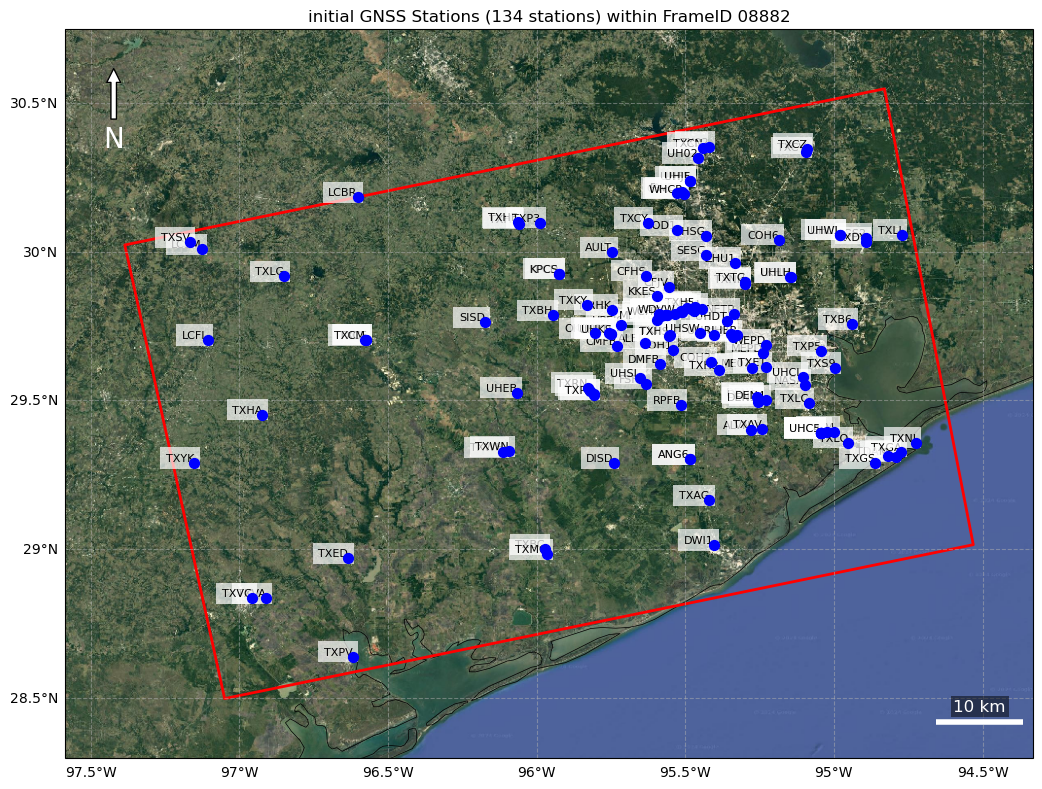

In [18]:
# plot initial GNSS stations with frame
plot_gnss_stations_frame(sites_df, geom, figname=f'{gnss_dir}/GNSS_stations_initial_F{frameID_str}.png', title=f'initial GNSS Stations ({initial_nsites} stations) within FrameID {frameID_str}')

Further filtering based on possible steps and identified significant steps

In [19]:
# Filtering GNSS stations based on possible steps
rem_stns = gnss_steps_eq_df['site'].unique()
filt_sites_df = sites_df[~sites_df['site'].isin(rem_stns)]      # based on earthquake

rem_stns = gnss_steps_ant_df['site'].unique()
filt_sites_df = filt_sites_df[~filt_sites_df['site'].isin(rem_stns)]        # based on equipment changes

In [20]:
# Filtering GNSS stations based on identified significant steps in timeseries
bad_stns = []

# downloading GNSS datasets
stations = list(sites_df['site'].values)

with tqdm(total=len(stations), desc="Processing stations", unit="station") as pbar:
    for stn in stations:
        pbar.set_description(f"Processing {stn}")

        gnss_obj = GNSS(site = stn, data_dir = gnss_dir)
        gnss_obj.open(print_msg=False)
        
        dates_stn = gnss_obj.dates
        dis_stn = np.sqrt(gnss_obj.dis_e**2 + gnss_obj.dis_n**2 + gnss_obj.dis_u**2)

        index_date = (dates_stn > start_date) & (dates_stn < end_date)      # index for selecting stations within DISP-S1 period

        detected_steps = detect_step_functions(dates_stn[index_date], dis_stn[index_date])

        time_gnss_diff = (dates_stn[index_date][-1] - dates_stn[index_date][0]).days
        measurement_density = len(dis_stn[index_date]) / time_gnss_diff     # filtering sparse GNSS measurements

        period_ratio_gnss = time_gnss_diff / DISP_S1_period     # filtering GNSS stations with low temporal coverage

        if (len(detected_steps) != 0) or (measurement_density <gnss_completeness_thr) or (period_ratio_gnss<gnss_coverage_thr):

            bad_stns.append(stn)

            # plotting bad stations in case of further investigation
            fig, ax = plt.subplots(figsize=(15,10))
            ax.plot(dates_stn[index_date], dis_stn[index_date],'.')
            ax.set_title(f'Station: {stn}')
            ax.set_xlabel('Dates', fontsize=16, fontweight='bold')
            ax.set_ylabel('GNSS measurements', fontsize=16, fontweight='bold')
            ax.set_xlim([start_date, end_date])
            ax.grid(axis='x')
            fig.savefig(f'{bad_gnss_dir}/{stn}_plot.png', bbox_inches='tight', dpi=300)
            plt.close()

        pbar.update(1)

Processing ZHU1: 100%|██████████| 134/134 [00:52<00:00,  2.55station/s]


In [21]:
print(f'GNSS stations with significant steps, low temporal coverage, or sparsity: {bad_stns}')

filt_sites_df = sites_df[~sites_df['site'].isin(bad_stns)].reset_index(drop=True)

filt_sites_df.to_csv(os.path.join(mintpy_dir,gnss_select_list_csv), index=None)     # this csv file will be used for DISP-S1 CalVal
filt_nsites, _ = filt_sites_df.shape

print(f'Number of filtered GNSS stations: {filt_nsites}')

GNSS stations with significant steps, low temporal coverage, or sparsity: ['CFJV', 'COH6', 'CSTA', 'HCC2', 'KPCS', 'LCBR', 'TX02', 'TXCF', 'TXCZ', 'TXDY', 'TXED', 'TXET', 'TXGS', 'TXH3', 'TXH5', 'TXH6', 'TXLC', 'TXNH', 'TXNJ', 'TXP3', 'TXRB', 'TXRG', 'TXS9', 'TXSV', 'TXYK', 'UH01', 'UHC4', 'UHC5', 'UHDT', 'UHJF', 'UHKS', 'UHSW', 'UTEX']
Number of filtered GNSS stations: 101


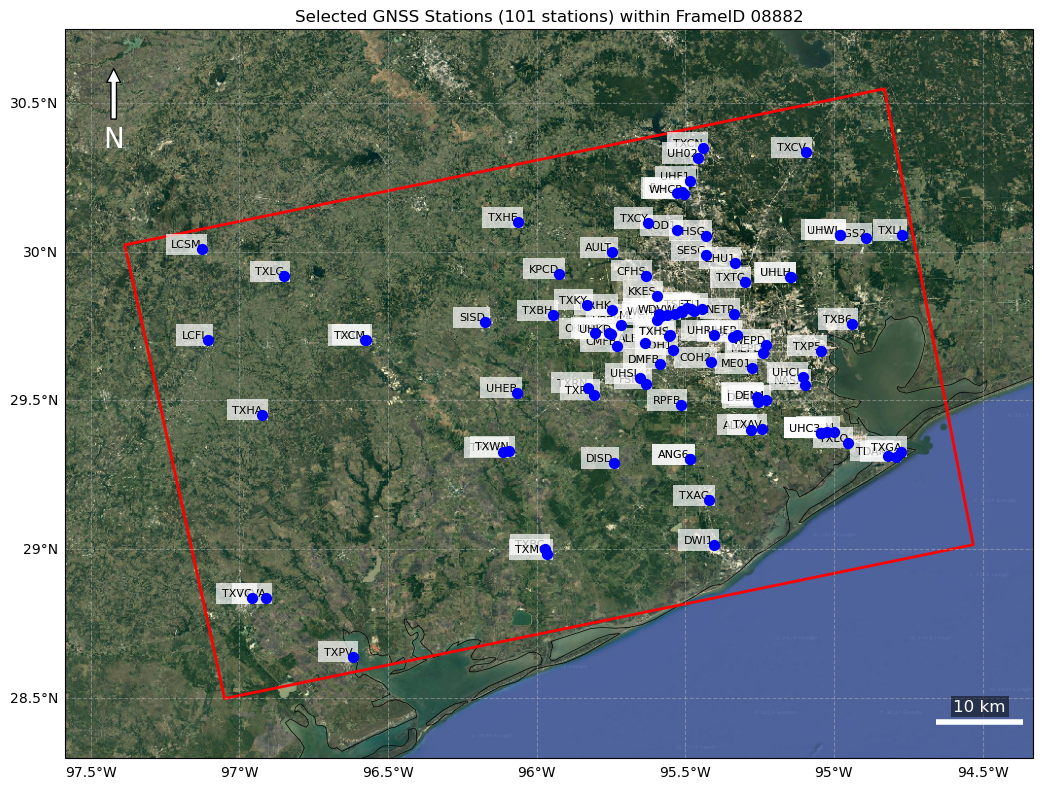

In [22]:
# plot final GNSS stations with frame to be used for DISP-S1 CalVal
plot_gnss_stations_frame(filt_sites_df, geom, figname=f'{gnss_dir}/GNSS_stations_filtered_F{frameID_str}.png', title=f'Selected GNSS Stations ({filt_nsites} stations) within FrameID {frameID_str}')